# PlotBot analyze

This tweeter bot will listen for a mention to analyze it's message. The sentiment of the last 500 tweets will be plotted and attached to the reply of the mention.

The bot runs for approx 5 mins.

The mentions are triggered by the call to the user @vero_guirlyn with message "PlotBot analyze"

tweet is @vero_guirlyn Plotbot analyze @CBCNews
Trigger sentiment analysis on ['@vero', '@cbcnews']
analyze(@cbcnews)
Dumped 500 tweets to the CSV file
doing plotting


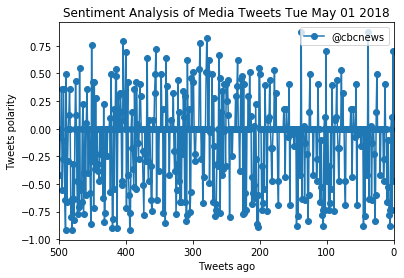

replied to vero_guirlyn


KeyboardInterrupt: 

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mar 23 16:49:13 2018

@author: guirlynolivar
"""

#The bot receives tweets via mentions 
#and in turn performs sentiment analysis on 
#the most recent twitter account specified in the mention
#example: @vero_guirlyn PlotBot analyze @cnn

# Dependencies
import tweepy
import config
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret)
auth.set_access_token(config.access_token, config.access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

# Setup Vader Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

today = datetime.now()

def human(tweeter_user):
    """ human
      apply regular known filters to the tweet to determine if the tweet
      came from a bot or a human. 
      Return True if it passes the filter assuming a real human sent the tweet
      False otherwise
    """
#    # "Real Person" Filters
    min_tweets = 5
    max_tweets = 10000
    max_followers = 2500
    max_following = 2500
    lang = "en"
    if (tweeter_user["followers_count"] < max_followers and
        tweeter_user["statuses_count"] > min_tweets and
        tweeter_user["statuses_count"] < max_tweets and
        tweeter_user["friends_count"] < max_following and
        tweeter_user["lang"] == lang):
        return True
    else:
       return False

 
def trigger(tweet):
    """ trigger
    decode the tweet to find the trigger text: PlotBot analyze
    call analyze if the is a mention
    """
    import re
    test_string = tweet.lower()
    pattern = r'(@[a-z]*[A-Z]*)'
    mentions = re.findall(pattern, test_string)
    print(f"Trigger sentiment analysis on {mentions}")
    for u in mentions:
        if u != "@vero":
            print(f'analyze({u})')
            analyze(u)
    return(u)
            
def listen(mention,oldest_tweet):
    """ listen
    performs a search for a tweet with the mention of the bot handle
    """
    tweet_seen = []
    if oldest_tweet == '':
        start_tweet = 0
    else:
        start_tweet = oldest_tweet
        
    public_tweets = api.search(
            mention,
            count=20,
            result_type="recent",
            max_id='')
  
    for tweet in public_tweets["statuses"]:
        tweetid = tweet['id']
        message = tweet['text']
        tweet_seen.append(tweetid)
        print(f"tweet is {tweet['text']}")
        if tweetid > start_tweet and human(tweet['user']):
            user = tweet['user']
            if trigger(message):
                print(f"doing plotting")
                if plotit():
                    reply(user['screen_name'],tweetid)
    
    return(max(tweet_seen))
    
def analyze(target_user):
    """ analyze
    given a user handle user, retrieve their latest 500 tweets and analyze
    using vader sentiment the different tweets. Dump to a csv
    """    
    sentiments =[]
    counter = 0
    for x in range(5): 
        public_tweets = api.user_timeline(target_user, count=100, page=x)
        for tweet in public_tweets:
            tweeter_text = tweet['text']
            vscores = analyzer.polarity_scores(tweeter_text)
            sentiments.append({'user':target_user,
                               'tn':counter,
                               'date':tweet['created_at'],
                               'compound':vscores['compound'],
                               'positive':vscores['pos'],
                               'negative':vscores['neg'],
                               'neutral':vscores['neu'],
                               'tweet':tweeter_text})
            counter+=1
        print(f"Collecting tweets page {x}...")
        time.sleep(10)
        
    # Aggregate into a dataframe the data collected
    sentiment_df = pd.DataFrame(sentiments) 
    sentiment_df.to_csv("media_sentiment_tweeter.csv")
    print(f"Dumped {counter} tweets to the CSV file")

    
def plotit():
    """ ploptit
    creates a plot of the values given
    """   
    try:
        with open("media_sentiment_tweeter.csv") as twfile:
            twanalysis = pd.read_csv(twfile, delimiter=',')
            mention = twanalysis['user'].unique()
            twanalysis.plot(x="tn", y="compound", marker='o',label=mention[0])
            
            # Incorporate the other graph properties
            title = "Sentiment Analysis of Media Tweets " + today.strftime("%a %b %d %Y")
            plt.title(title)
            plt.ylabel("Tweets polarity")
            plt.xlabel("Tweets ago")
            plt.xlim(500,0) # inverse the x- axis to show decrease over time
            # Save the figure1
            plt.savefig("sentiment_analysis_plotted.png")
            plt.legend(loc='best')
            plt.show()
            return True
    except:
        print("error with twitter data retrieval from csv")
        return False
        
def reply(tweet_author, tweet_id):
    """ reply
    reply to the tweet that triggered the request with the generated plot of the 
    sentiment analysis
    """
    try:
        api.update_with_media("sentiment_analysis_plotted.png", 
                              status="sentimenmt analysis request from @"+tweet_author, 
                              in_reply_to_status_id=tweet_id)
        print(f"replied to {tweet_author}")
    except Exception:            
        print(f"something went wrong with the reply to {tweet_author}")
    
"""

"""
max_time = 300 #run for five minutes
start_time = time.time()  # remember when we started
tw_id=''
while (time.time() - start_time) < max_time:
    tw_id=listen('@vero_guirlyn Plotbot analyze',tw_id)   
    time.sleep(120)
    
print(f"Waited around for {max_time} seconds plotbot mention, done now")    
  
